In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import copy
import lmdb
# display plots in this notebook
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['figure.figsize'] = (10, 10) 

# Make sure that caffe is on the python path:
caffe_root = ''  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

In [3]:
# Set the right path to your model definition file, pretrained model weights,
# and the image you would like to classify.
MODEL_FILE = 'models/deep_mammo/alex_dropout_0_5_deploy.prototxt'
WEIGHTS_FILE = '/mnt/weights/pretrained.2844_iter.alex_reg_0_005_0_5_dropout.caffemodel'
IMAGE_FILE = '/mnt/2x_augmented_train/P_00481_RIGHT_MLO_1_4_0.tif'
MEAN_FILE = '/home/ubuntu/2x_padding_224x224_dataset/mass_2x_padding_dataset_train_mean.binaryproto'
val_lmdb = "/home/ubuntu/2x_padding_224x224_dataset/mass_2x_padding_dataset_val_lmdb"

caffe.set_mode_cpu()

In [4]:
def get_mean_image():
    mean_blobproto_new = caffe.proto.caffe_pb2.BlobProto()
    f = open(MEAN_FILE, 'rb')
    mean_blobproto_new.ParseFromString(f.read())
    mean_image = caffe.io.blobproto_to_array(mean_blobproto_new)
    f.close()
    return mean_image

mean = get_mean_image()

In [5]:
def get_val_images(n=10):
    lmdb_env = lmdb.open(val_lmdb)
    lmdb_txn = lmdb_env.begin()
    lmdb_cursor = lmdb_txn.cursor()
    X, y = [], []
    i = 0
    for key, value in lmdb_cursor:
        datum = caffe.proto.caffe_pb2.Datum()
        datum.ParseFromString(value)
        label = int(datum.label)
        image = caffe.io.datum_to_array(datum)
        image = image.astype(np.uint8)
        X.append(image)
        y.append(label)
        i += 1
        if i == n:
            break
    
    return np.array(X), np.array(y)

In [6]:
X, y = get_val_images()
print X.shape
print y

(10, 3, 224, 224)
[0 0 1 1 0 0 1 1 1 1]


In [7]:
def blur_image(X):
  """
  A very gentle image blurring operation, to be used as a regularizer for image
  generation.
  
  Inputs:
  - X: Image data of shape (N, 3, H, W)
  
  Returns:
  - X_blur: Blurred version of X, of shape (N, 3, H, W)
  """
  w_blur = np.zeros((3, 3, 3, 3))
  b_blur = np.zeros(3)
  blur_param = {'stride': 1, 'pad': 1}
  for i in xrange(3):
    w_blur[i, i] = np.asarray([[1, 2, 1], [2, 188, 2], [1, 2, 1]], dtype=np.float32)
  w_blur /= 200.0
  return conv_forward_fast(X, w_blur, b_blur, blur_param)[0]


def preprocess_image(img, mean_img, mean='image'):
  """
  Convert to float, transepose, and subtract mean pixel
  
  Input:
  - img: (H, W, 3)
  
  Returns:
  - (1, 3, H, 3)
  """
  if mean == 'image':
    mean = mean_img
  elif mean == 'pixel':
    mean = mean_img.mean(axis=(1, 2), keepdims=True)
  elif mean == 'none':
    mean = 0
  else:
    raise ValueError('mean must be image or pixel or none')
  return img.astype(np.float32).transpose(2, 0, 1)[None] - mean

def deprocess_image(img, mean_img, mean='image', renorm=False):
  """
  Add mean pixel, transpose, and convert to uint8
  
  Input:
  - (1, 3, H, W) or (3, H, W)
  
  Returns:
  - (H, W, 3)
  """
  if mean == 'image':
    mean = mean_img
  elif mean == 'pixel':
    mean = mean_img.mean(axis=(1, 2), keepdims=True)
  elif mean == 'none':
    mean = 0
  else:
    raise ValueError('mean must be image or pixel or none')
  if img.ndim == 3:
    img = img[None]
  img = (img + mean)[0].transpose(1, 2, 0)
  if renorm:
    low, high = img.min(), img.max()
    img = 255.0 * (img - low) / (high - low)
  return img.astype(np.uint8)


In [8]:
def create_class_visualization(target_y, net, **kwargs):
  """
  Perform optimization over the image to generate class visualizations.
  
  Inputs:
  - target_y: Integer in the range [0, 100) giving the target class
  - model: A PretrainedCNN that will be used for generation
  
  Keyword arguments:
  - learning_rate: Floating point number giving the learning rate
  - blur_every: An integer; how often to blur the image as a regularizer
  - l2_reg: Floating point number giving L2 regularization strength on the image;
    this is lambda in the equation above.
  - max_jitter: How much random jitter to add to the image as regularization
  - num_iterations: How many iterations to run for
  - show_every: How often to show the image
  """
  
  learning_rate = kwargs.pop('learning_rate', 10000)
  blur_every = kwargs.pop('blur_every', 1)
  l2_reg = kwargs.pop('l2_reg', 1e-6)
  max_jitter = kwargs.pop('max_jitter', 8)
  num_iterations = kwargs.pop('num_iterations', 100)
  show_every = kwargs.pop('show_every', 5)
  
  X = np.random.randn(10, 3, 224, 224)
  plt.imshow(deprocess_image(X[0], mean))
  plt.gcf().set_size_inches(3, 3)
  plt.axis('off')
  plt.show()
  for t in xrange(num_iterations):
    X[:,1,:,:] = X[:,0,:,:]
    X[:,2,:,:] = X[:,0,:,:]
    print 'Iteration: %i/%i' % (t, num_iterations)
    # As a regularizer, add random jitter to the image
    ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
    X = np.roll(np.roll(X, ox, -1), oy, -2)

    dX = None
    ############################################################################
    # TODO: Compute the image gradient dX of the image with respect to the     #
    # target_y class score. This should be similar to the fooling images. Also #
    # add L2 regularization to dX and update the image X using the image       #
    # gradient and the learning rate.                                          #
    ############################################################################
    out = net.forward_all(data=X-mean)
    labels = np.zeros((10,2))
    labels[:,target_y] = 1
    diffs = net.backward(**{net.outputs[0]: labels})
    dX = diffs['data']
    dX += 2*l2_reg*X
    X += learning_rate*dX
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################
    
    # Undo the jitter
    X = np.roll(np.roll(X, -ox, -1), -oy, -2)
    
    # As a regularizer, clip the image
    X = np.clip(X, -131, 255.0 - 131)
    
    # As a regularizer, periodically blur the image
    #if t % blur_every == 0:
    #  X = blur_image(X)
    
    # Periodically show the image
    if t % show_every == 0:
      plt.imshow(deprocess_image(X[0], mean))
      plt.gcf().set_size_inches(3, 3)
      plt.axis('off')
      plt.show()
  return X

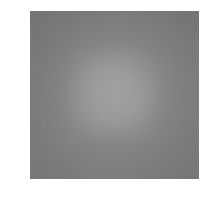

Iteration: 0/200


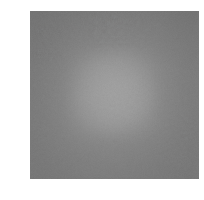

Iteration: 1/200
Iteration: 2/200
Iteration: 3/200
Iteration: 4/200
Iteration: 5/200
Iteration: 6/200
Iteration: 7/200
Iteration: 8/200
Iteration: 9/200
Iteration: 10/200


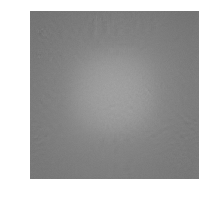

Iteration: 11/200
Iteration: 12/200
Iteration: 13/200
Iteration: 14/200
Iteration: 15/200
Iteration: 16/200
Iteration: 17/200
Iteration: 18/200
Iteration: 19/200
Iteration: 20/200


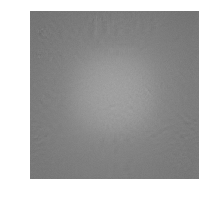

Iteration: 21/200
Iteration: 22/200
Iteration: 23/200
Iteration: 24/200
Iteration: 25/200
Iteration: 26/200
Iteration: 27/200
Iteration: 28/200
Iteration: 29/200
Iteration: 30/200


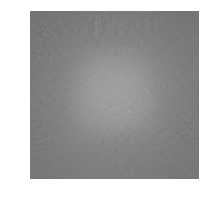

Iteration: 31/200
Iteration: 32/200
Iteration: 33/200
Iteration: 34/200
Iteration: 35/200
Iteration: 36/200
Iteration: 37/200
Iteration: 38/200
Iteration: 39/200
Iteration: 40/200


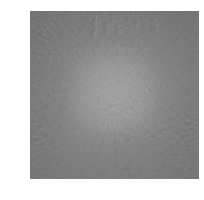

Iteration: 41/200
Iteration: 42/200
Iteration: 43/200
Iteration: 44/200
Iteration: 45/200
Iteration: 46/200
Iteration: 47/200
Iteration: 48/200
Iteration: 49/200
Iteration: 50/200


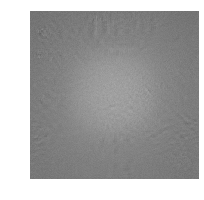

Iteration: 51/200
Iteration: 52/200
Iteration: 53/200
Iteration: 54/200
Iteration: 55/200
Iteration: 56/200
Iteration: 57/200
Iteration: 58/200
Iteration: 59/200
Iteration: 60/200


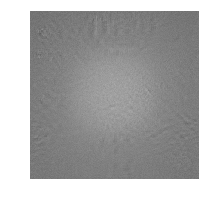

Iteration: 61/200
Iteration: 62/200
Iteration: 63/200
Iteration: 64/200
Iteration: 65/200
Iteration: 66/200
Iteration: 67/200
Iteration: 68/200
Iteration: 69/200
Iteration: 70/200


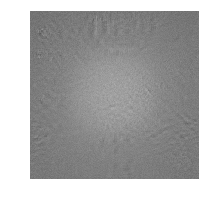

Iteration: 71/200
Iteration: 72/200
Iteration: 73/200
Iteration: 74/200
Iteration: 75/200
Iteration: 76/200
Iteration: 77/200
Iteration: 78/200
Iteration: 79/200
Iteration: 80/200


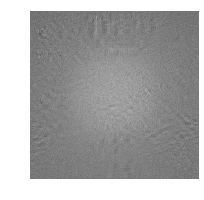

Iteration: 81/200
Iteration: 82/200
Iteration: 83/200
Iteration: 84/200
Iteration: 85/200
Iteration: 86/200
Iteration: 87/200
Iteration: 88/200
Iteration: 89/200
Iteration: 90/200


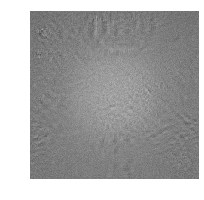

Iteration: 91/200
Iteration: 92/200
Iteration: 93/200
Iteration: 94/200
Iteration: 95/200
Iteration: 96/200
Iteration: 97/200
Iteration: 98/200
Iteration: 99/200
Iteration: 100/200


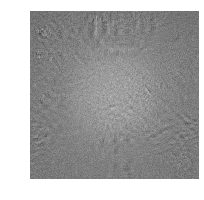

Iteration: 101/200
Iteration: 102/200
Iteration: 103/200
Iteration: 104/200
Iteration: 105/200
Iteration: 106/200
Iteration: 107/200
Iteration: 108/200
Iteration: 109/200
Iteration: 110/200


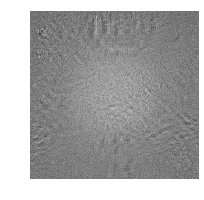

Iteration: 111/200
Iteration: 112/200
Iteration: 113/200
Iteration: 114/200
Iteration: 115/200
Iteration: 116/200
Iteration: 117/200
Iteration: 118/200
Iteration: 119/200
Iteration: 120/200


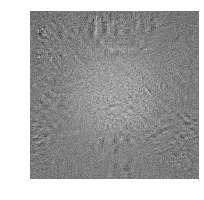

Iteration: 121/200
Iteration: 122/200
Iteration: 123/200
Iteration: 124/200
Iteration: 125/200
Iteration: 126/200
Iteration: 127/200
Iteration: 128/200
Iteration: 129/200
Iteration: 130/200


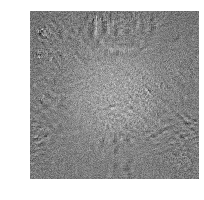

Iteration: 131/200
Iteration: 132/200
Iteration: 133/200
Iteration: 134/200
Iteration: 135/200
Iteration: 136/200
Iteration: 137/200
Iteration: 138/200
Iteration: 139/200
Iteration: 140/200


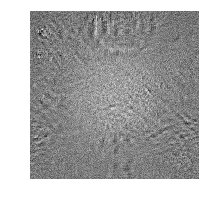

Iteration: 141/200
Iteration: 142/200
Iteration: 143/200
Iteration: 144/200
Iteration: 145/200
Iteration: 146/200
Iteration: 147/200
Iteration: 148/200
Iteration: 149/200
Iteration: 150/200


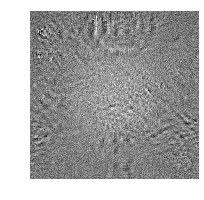

Iteration: 151/200
Iteration: 152/200
Iteration: 153/200
Iteration: 154/200
Iteration: 155/200
Iteration: 156/200
Iteration: 157/200
Iteration: 158/200
Iteration: 159/200
Iteration: 160/200


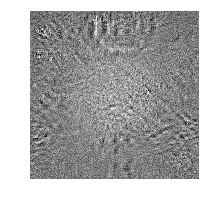

Iteration: 161/200
Iteration: 162/200
Iteration: 163/200
Iteration: 164/200
Iteration: 165/200
Iteration: 166/200
Iteration: 167/200
Iteration: 168/200
Iteration: 169/200
Iteration: 170/200


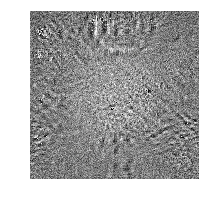

Iteration: 171/200
Iteration: 172/200
Iteration: 173/200
Iteration: 174/200
Iteration: 175/200
Iteration: 176/200
Iteration: 177/200
Iteration: 178/200
Iteration: 179/200
Iteration: 180/200


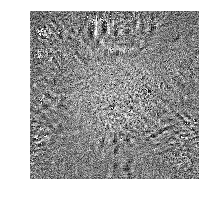

Iteration: 181/200
Iteration: 182/200
Iteration: 183/200
Iteration: 184/200
Iteration: 185/200
Iteration: 186/200
Iteration: 187/200
Iteration: 188/200
Iteration: 189/200
Iteration: 190/200


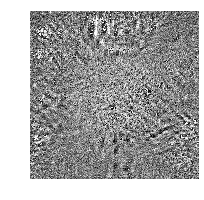

Iteration: 191/200
Iteration: 192/200
Iteration: 193/200
Iteration: 194/200
Iteration: 195/200
Iteration: 196/200
Iteration: 197/200
Iteration: 198/200
Iteration: 199/200


In [10]:
net = caffe.Net(MODEL_FILE, WEIGHTS_FILE, caffe.TEST)
X = create_class_visualization(1, net, learning_rate=10000, num_iterations=200, show_every=10)

Iteration: 0/100


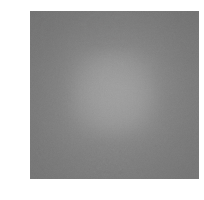

Iteration: 1/100
Iteration: 2/100
Iteration: 3/100
Iteration: 4/100
Iteration: 5/100


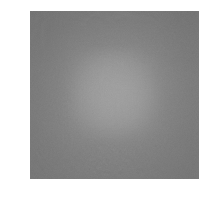

Iteration: 6/100
Iteration: 7/100
Iteration: 8/100
Iteration: 9/100
Iteration: 10/100


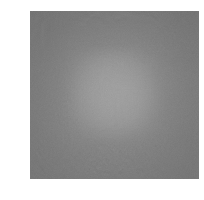

Iteration: 11/100
Iteration: 12/100
Iteration: 13/100
Iteration: 14/100
Iteration: 15/100


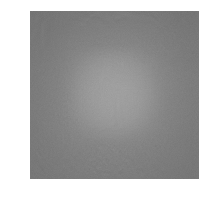

Iteration: 16/100
Iteration: 17/100
Iteration: 18/100
Iteration: 19/100
Iteration: 20/100


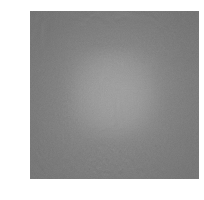

Iteration: 21/100
Iteration: 22/100
Iteration: 23/100
Iteration: 24/100
Iteration: 25/100


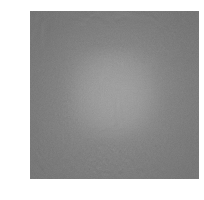

Iteration: 26/100
Iteration: 27/100
Iteration: 28/100
Iteration: 29/100
Iteration: 30/100


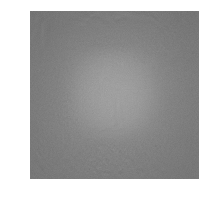

Iteration: 31/100
Iteration: 32/100
Iteration: 33/100
Iteration: 34/100
Iteration: 35/100


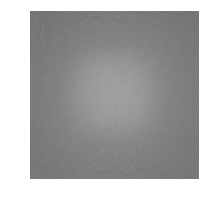

Iteration: 36/100
Iteration: 37/100
Iteration: 38/100
Iteration: 39/100
Iteration: 40/100


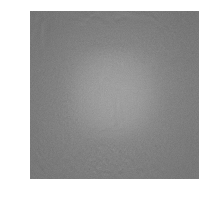

Iteration: 41/100
Iteration: 42/100
Iteration: 43/100
Iteration: 44/100
Iteration: 45/100


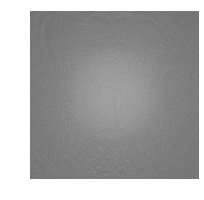

Iteration: 46/100
Iteration: 47/100
Iteration: 48/100
Iteration: 49/100
Iteration: 50/100


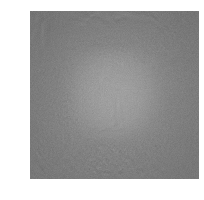

Iteration: 51/100
Iteration: 52/100
Iteration: 53/100
Iteration: 54/100
Iteration: 55/100


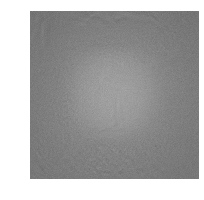

Iteration: 56/100
Iteration: 57/100
Iteration: 58/100
Iteration: 59/100
Iteration: 60/100


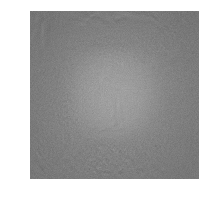

Iteration: 61/100
Iteration: 62/100
Iteration: 63/100
Iteration: 64/100
Iteration: 65/100


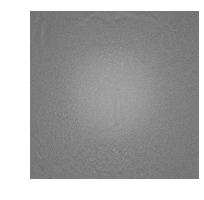

Iteration: 66/100
Iteration: 67/100
Iteration: 68/100
Iteration: 69/100
Iteration: 70/100


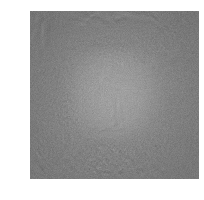

Iteration: 71/100
Iteration: 72/100
Iteration: 73/100
Iteration: 74/100
Iteration: 75/100


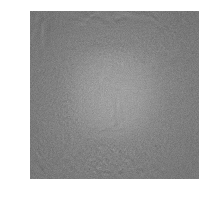

Iteration: 76/100
Iteration: 77/100
Iteration: 78/100
Iteration: 79/100
Iteration: 80/100


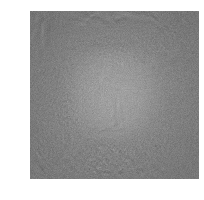

Iteration: 81/100
Iteration: 82/100
Iteration: 83/100
Iteration: 84/100
Iteration: 85/100


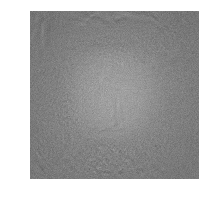

Iteration: 86/100
Iteration: 87/100
Iteration: 88/100
Iteration: 89/100
Iteration: 90/100


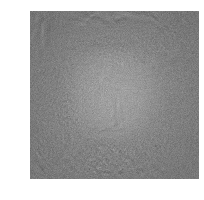

Iteration: 91/100
Iteration: 92/100
Iteration: 93/100
Iteration: 94/100
Iteration: 95/100


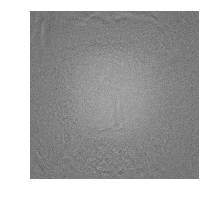

Iteration: 96/100
Iteration: 97/100
Iteration: 98/100
Iteration: 99/100


In [62]:
X = create_class_visualization(0, net)

In [6]:
# input_image = caffe.io.load_image(IMAGE_FILE)
# plt.imshow(input_image)
mean_image = get_mean_image()
# # input_image = np.expand_dims(np.transpose(input_image, (2, 0, 1)), axis=0)
# input_image = np.transpose(input_image, (2, 1, 0))

net = caffe.Net(MODEL_FILE, WEIGHTS_FILE, caffe.TEST)
caffeLabel = np.zeros_like(net.blobs['prob'].data)
caffeLabel[np.arange(caffeLabel.shape[0]), y] = 1
print caffeLabel
out = net.forward_all(data=X - mean_image)
print net.blobs['prob'].diff.shape
print net.blobs['prob'].diff
print net.blobs['prob'].data.shape
print net.blobs['prob'].data
diffs = net.backward(**{net.outputs[0]: caffeLabel})
dX = diffs['data']
print dX.shape

[[ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]]
(10, 2)
[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
(10, 2)
[[  4.35571633e-02   9.56442833e-01]
 [  8.79545391e-01   1.20454609e-01]
 [  2.32028984e-03   9.97679770e-01]
 [  3.04412388e-04   9.99695659e-01]
 [  9.98912573e-01   1.08748593e-03]
 [  7.37296343e-01   2.62703687e-01]
 [  8.07723496e-03   9.91922736e-01]
 [  4.45740483e-07   9.99999523e-01]
 [  9.91127687e-04   9.99008894e-01]
 [  8.57856333e-01   1.42143682e-01]]
(10, 3, 224, 224)


(224, 224, 3)


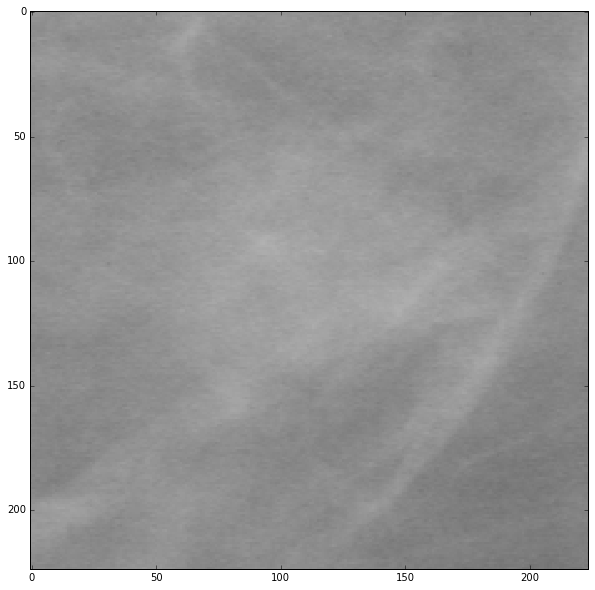

In [11]:
img = X[0]
img = img
print img.shape
plt.imshow(img)

In [18]:
saliency = np.amax(np.abs(dX), axis=1)
class_names = {1: 'Malignant', 0: 'Benign'}

In [34]:
def show_saliency_maps(X, y, saliency, name):
    n = X.shape[0]
    for i in xrange(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(X[i].transpose(1, 2, 0))
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, n, n + i + 1)
        plt.imshow(saliency[i])
        plt.axis('off')
    plt.gcf().set_size_inches(10, 4)
    plt.savefig(name)
    plt.show()

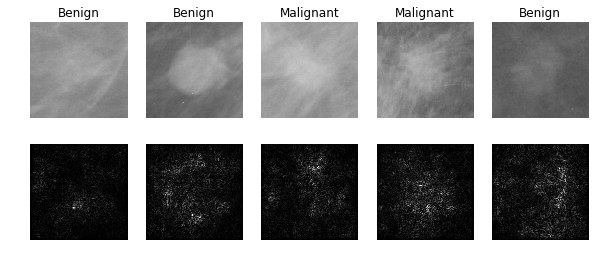

In [35]:
show_saliency_maps(X[:5], y[:5], saliency[:5], 'saliency1.png')

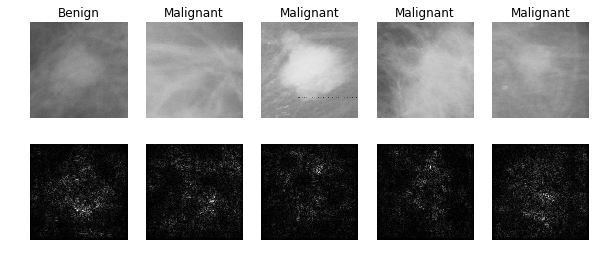

In [36]:
show_saliency_maps(X[5:], y[5:], saliency[5:], 'saliency2.png')